In [1]:
## load packages 
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import copy
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import StackingClassifier

from sklearn.metrics import balanced_accuracy_score, recall_score,f1_score
from sklearn.metrics import roc_curve, roc_auc_score
## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# pd.set_option('display.max_colwidth', None)

## Dataset

In [2]:
df = pd.read_csv(r"C:\Users\Lahiri\tedsd_puf_2020.csv")
df.head(5)
df.shape 

,DISYR,CASEID,STFIPS,CBSA2010,EDUC,MARSTAT,SERVICES,DETCRIM,LOS,PSOURCE,...,TRNQFLG,BARBFLG,SEDHPFLG,INHFLG,OTCFLG,OTHERFLG,DIVISION,REGION,IDU,ALCDRUG
0,2020,1243074,2,-9,3,1,7,-9,35,1,...,0,0,0,0,0,0,9,4,0,3
1,2020,1168758,2,-9,3,2,7,-9,29,1,...,0,0,0,0,0,0,9,4,0,1
2,2020,1150846,2,-9,1,1,7,-9,36,1,...,0,0,0,0,0,0,9,4,0,3
3,2020,1121864,2,-9,3,2,7,-9,37,1,...,0,0,0,0,0,0,9,4,0,3
4,2020,1180820,2,-9,3,2,7,-9,36,1,...,0,0,0,0,0,0,9,4,0,3


(1391393, 76)

In [3]:
#Creating codebook dictionary for ease of access later

In [4]:
codebook = {'DISYR': 'Year of Discharge',
 'CASEID': 'ID',
 'STFIPS': 'STATE',
 'EDUC' : 'EDUCATION LEVEL',
 'MARSTAT' : 'Marital Status',
 'SERVICES' : ' Type of treatment service/setting at admission',
 'DETCRIM': 'Detailed criminal justice referral',
 'LOS' : ' Length of stay in treatment' ,
 'PSOURCE' : 'Referral source' ,
 'NOPRIOR' : 'Previous substance use treatment episodes',
 'ARRESTS' : ' Arrests in past 30 days prior to admission',
 'EMPLOY' : ' Employment status at admission' ,
 'METHUSE': 'Medication-assisted opioid therapy',
 'PSYPROB': 'Co-occurring mental and substance use disorders' ,
 'PREG' : 'Pregnant at admission' ,
 'GENDER': 'GENDER',
 'VET': 'Veteran status',
 'LIVARAG': 'Living arrangements at admission' ,
 'DAYWAIT': 'Days waiting to enter substance use treatment',
 'SERVICES_D': 'Type of treatment service/setting at discharge' ,
 'REASON' : 'Reason for discharge',
 'EMPLOY_D': 'Employment status at discharge',
 'LIVARAG_D' : 'Living arrangements at discharge',
 'ARRESTS_D': 'Arrests in past 30 days prior to discharge',
 'DSMCRIT': 'DSM diagnosis',
 'AGE': 'AGE',
 'RACE': 'RACE',
 'ETHNIC': 'ETHNICITY',
 'DETNLF': 'Detailed not in labor force category at admission',
 'DETNLF_D': 'Detailed not in labor force category at discharge',
 'PRIMINC': 'Source of income/support',
 'SUB1': 'Substance use at admission (primary)',
 'SUB2': 'Substance use at admission (secondary)',
 'SUB3': 'Substance use at admission (tertiary)',
 'SUB1_D': 'Substance use at discharge (primary)',
 'SUB2_D': 'Substance use at discharge (secondary)',
 'SUB3_D': 'Substance use at discharge (tertiary)',
 'ROUTE1': 'Route of administration (primary)',
 'ROUTE2': 'Route of administration (secondary)' ,
 'ROUTE3': 'Route of administration (tertiary)',
 'FREQ1': ' Frequency of use at admission (primary)',
 'FREQ2': ' Frequency of use at admission (secondary)',
 'FREQ3': ' Frequency of use at admission (tertiary)',
 'FREQ1_D': ' Frequency of use at discharge (primary)',
 'FREQ2_D': ' Frequency of use at discharge (secondary)',
 'FREQ3_D': ' Frequency of use at discharge (tertiary)',
 'FRSTUSE1': 'Age at first use (primary)',
 'FRSTUSE2': 'Age at first use (secondary)',
 'FRSTUSE3': 'Age at first use (tertiary)',
 'HLTHINS': ' health insurance at admission. The insurance may or may not cover behavioral health treatment',
 'PRIMPAY': 'Payment source, primary (expected or actual)',
 'FREQ_ATND_SELF_HELP': 'Attendance at substance use self-help groups in past 30 days prior to admission',
 'FREQ_ATND_SELF_HELP_D': 'Attendance at substance use self-help groups in past 30 days prior to discharge',
 'ALCFLG': 'Alcohol reported at admission(alcohol was reported as the primary, secondary, or tertiary substance)' ,
 'COKEFLG': 'Cocaine/crack reported at admission',
 'MARFLG': 'Marijuana/hashish reported at admission',
 'HERFLG': 'Heroin reported at admission',
 'METHFLG': 'Non-rx methadone reported at admission',
 'OPSYNFLG': 'Other opiates/synthetics reported at admission',
 'PCPFLG': 'PCP reported at admission',
 'HALLFLG': 'Hallucinogens reported at admission',
 'MTHAMFLG': 'Methamphetamine/speed reported at admission',
 'AMPHFLG': 'Other amphetamines reported at admission',
 'STIMFLG': 'Other stimulants reported at admission',
 'BENZFLG': 'Benzodiazepines reported at admission',
 'TRNQFLG': 'Other tranquilizers reported at admission',
 'BARBFLG': 'Barbiturates reported at admission',
 'SEDHPFLG': 'Other sedatives/hypnotics reported at admission',
 'INHFLG': 'Inhalants reported at admission',
 'OTCFLG': 'Over-the-counter medication reported at admission',
 'OTHERFLG': 'Other drug reported at admission',
 'DIVISION': 'DIVISION',
 'REGION': 'REGION',
 'IDU': 'Current IV drug use reported at admission',
 'ALCDRUG': 'Substance use type'}

In [5]:
#Feature list 

cols = ['CASEID',
 'LIVARAG',
 'EDUC',
 'MARSTAT',
 'SERVICES' ,
 'DETCRIM',
 'NOPRIOR' ,
 'ARRESTS' ,
 'EMPLOY' ,
 'PSYPROB',
 'PREG',
 'GENDER',
 'VET',
 'DSMCRIT',
 'AGE',
 'RACE',
 'ETHNIC',
 'PRIMINC',
 'SUB1',
 'SUB2',
 'SUB3',
 'ROUTE1',
 'FREQ1',
 'FRSTUSE1',
 'FRSTUSE2',
 'FRSTUSE3',
 'FREQ_ATND_SELF_HELP',
 'IDU',
 'ALCDRUG',
 'LIVARAG_D']

#For later subsetting of training and testing columns 
cols2 = [i for i in cols]
cols2.remove('CASEID')
cols2.remove('LIVARAG_D')

In [6]:
#Subsetting to final feature list 
df =df[cols]

#Dropping all cases where target variable is missing
df = df[df.LIVARAG_D != -9] 

## Pre-Processing

Grouping variables in order to reduce dimensionality, easier interpretability and retaining groups with significantly large frequencies

In [7]:

df['RACE'] = np.where(df['RACE'].isin([1,2]),1, df['RACE'])
df['RACE'] = np.where(~df['RACE'].isin([1,4,5,6,-9]),0, df['RACE'])

df['SUB1'] = np.where(df['SUB1'] == 11,10, df['SUB1'])

for i in ['SUB1']:
    df[i] = np.where(~df[i].isin([2,5,3,10,4,-9]),1,df[i])

df = df.astype('int')
df.replace(-9, np.nan, inplace=True)

df['min_firstuse'] = df[['FRSTUSE1','FRSTUSE2','FRSTUSE3']].min(axis = 1, skipna = True)

df['min_firstuse'] = np.where((df['min_firstuse']>= 2)&(df['min_firstuse']<= 3), 2, df['min_firstuse'])
df['min_firstuse'] = np.where((df['min_firstuse']>= 4)&(df['min_firstuse']<= 6), 3, df['min_firstuse'])
df['min_firstuse'] = np.where(df['min_firstuse'] == 7, 4, df['min_firstuse'])


df['DETCRIM'] = np.where(df['DETCRIM'].isna(),0, df['DETCRIM'])
df['DSMCRIT'] = np.where(df['DSMCRIT'].isin([1,3,4,9]),0, 
                         np.where(df['DSMCRIT'].isin([2,8,11]),1,
                                  np.where(df['DSMCRIT'].isin([5,12]),2,
                                           np.where(df['DSMCRIT'].isin([7,10]),3,
                                                    np.where(df['DSMCRIT'].isin([6,13]),4,df['DSMCRIT'])))))

df['AGE']= np.where(df['AGE'] == 1,1,
                        np.where(df['AGE'].isin([3,4]),3,
                                 np.where(df['AGE'].isin([5,6]),4,
                                          np.where(df['AGE'].isin([7,8]),5,
                                                   np.where(df['AGE'].isin([9,10,11,12]),6,df['AGE'])))))

df['ETHNIC']= np.where(df['ETHNIC'].isin([3,5]),3,df['ETHNIC'])

                            
df[['SUB1','SUB2','SUB3']].copy().replace(np.nan,0, inplace=True)
df['n_sub1'] = np.where(df['SUB1'].notna(),1,0)
df['n_sub2'] = np.where(df['SUB2'].notna(),1,0)
df['n_sub3'] = np.where(df['SUB3'].notna(),1,0)
df['n_sub'] = df[['n_sub1','n_sub2','n_sub3']].count(axis=1)
df['n_sub'].astype('category')

df['LIVARAG'] = np.where(df['LIVARAG'].isin([2,3]),0,df['LIVARAG'])
df['LIVARAG_D'] = np.where(df['LIVARAG_D'].isin([2,3]),0,1)

df.drop(columns = ['n_sub1','n_sub2','n_sub3','SUB2','SUB3','FRSTUSE1','FRSTUSE2','FRSTUSE3'], inplace = True)
for i in ['SUB2','SUB3','FRSTUSE1','FRSTUSE2','FRSTUSE3']:
    cols2.remove(i)

0          3
1          3
2          3
3          3
4          3
          ..
1391388    3
1391389    3
1391390    3
1391391    3
1391392    3
Name: n_sub, Length: 1083555, dtype: category
Categories (1, int64): [3]

In [8]:
print('Proportion who ended up homeless %.3f' %(df[(df.LIVARAG == 1)&(df.LIVARAG_D == 0)].shape[0]/df.shape[0]))
print('Proportion who ended up not homeless %.3f' %(df[(df.LIVARAG == 0)&(df.LIVARAG_D == 1)].shape[0]/df.shape[0]))
print('Proportion who were never homeless %.3f' %(df[(df.LIVARAG == 0)&(df.LIVARAG_D == 0)].shape[0]/df.shape[0]))
print('Proportion who were always homeless %.3f' %(df[(df.LIVARAG == 1)&(df.LIVARAG_D == 1)].shape[0]/df.shape[0]))

Proportion who ended up homeless 0.045
Proportion who ended up not homeless 0.016
Proportion who were never homeless 0.809
Proportion who were always homeless 0.117


## Imputation, Sampling and Variable Encoding

In [9]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='most_frequent')
df2 = imp.fit_transform(df)
df2 = pd.DataFrame(df2, columns = df.columns.tolist())

In [10]:
#Creating our feature and target matrices
X = df2.drop(columns = ['LIVARAG_D','CASEID'])
y = df2['LIVARAG_D']

#Label Encoding 
encoder = LabelEncoder()
X[cols2] = X[cols2].apply(encoder.fit_transform)
y = encoder.fit_transform(y)

#Creating dummies for categorical variables
X_dum = pd.get_dummies(X, columns= cols2, drop_first = True)

#Creating copy dataframe, from which we undertake sampling 
X_sub = copy.deepcopy(X_dum)
X_sub['LIVARAG_D'] = y

a_1 = X_sub[(X_sub.LIVARAG_1 == 1)&(X_sub.LIVARAG_D == 0)]
a_3 = X_sub[(X_sub.LIVARAG_1 == 0)&(X_sub.LIVARAG_D == 0)].sample(250000, replace = False, random_state = 1)
a_2 = X_sub[(X_sub.LIVARAG_D == 1)]
sampled_df = pd.concat([a_1,a_2,a_3])

X = sampled_df.drop(columns = ['LIVARAG_D'])
y = sampled_df['LIVARAG_D']

## Cross Validation and Hyper-parameter tuning with Optuna

Due to the nature of Optuna's algorithm, the hyper parameters for which we recieve the best cross validation result, gives us both the: The hyper parameters and cross-validation results

**The command to begin tuning has been commented out, since it is computationally very intensive and can take almost 4 hours to finish. Code can be uncommented to be run**

In [11]:
rf = RandomForestClassifier()

In [12]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50,300)
    max_depth = int(trial.suggest_int('max_depth', 10,30))
    min_samples = int(trial.suggest_int('min_samples_split',20,10000))
    min_samples_leaf = int(trial.suggest_int('min_samples_leaf',100,1000))
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split = min_samples,min_samples_leaf= min_samples_leaf, n_jobs = -1 )
    return cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=5, scoring = 'balanced_accuracy').mean()

In [13]:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=68)

In [14]:
def objective(trial):
    penalty = trial.suggest_categorical('penalty',['l2', 'l1', 'elasticnet'])
    wgt = trial.suggest_categorical('class_weight',['balanced', 'none'])
    l1_ratio= trial.suggest_float('l1_ratio', 0.1, 1.0)
    clf = LogisticRegression(penalty=penalty, class_weight = wgt, solver = 'saga', l1_ratio =l1_ratio, n_jobs = -1 )
    return cross_val_score(clf, X, y, n_jobs=-1, cv=5, scoring = 'balanced_accuracy').mean()

In [15]:
# log_study = optuna.create_study(direction='maximize')
# log_study.optimize( objective, n_trials=15, n_jobs = -1)

In [16]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 100)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.7)
    gamma = trial.suggest_float('gamma', 0.0001, 1.0)
    reg_alpha = trial.suggest_float('reg_alpha', 0.0, 1.0)
    xgb_model = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, gamma=gamma,reg_alpha = reg_alpha, n_jobs = -1)
    return cross_val_score(xgb_model, X, y, n_jobs=-1, cv=5, scoring='balanced_accuracy').mean()

In [17]:
# xg_study = optuna.create_study(direction='maximize')
# xg_study.optimize(objective, n_trials=60)

# Training 

In [18]:
#Creating list of indices for variables which need to oversmapled using SMOTE
col_list = [0]
for i in range(2,79,1):
    col_list.append(i)

### SMOTE-NC based oversampling

In [19]:
X_train,X_test,y_train,y_test = train_test_split(X.iloc[:,1:],y, stratify = y, test_size = 0.3, random_state = 1 )

sampling_strategy = {1: len(y_train[y_train == 0]), 0: len(y_train[y_train == 0])}

# Create SMOTE object with dictionary-based sampling strategy
smote = SMOTENC(sampling_strategy=sampling_strategy,categorical_features = col_list, random_state = 1)

# Apply SMOTE to the training data
X_train, y_train = smote.fit_resample(X_train, y_train)

In [20]:
# We keep copies of the dataset to be later used in understanding model errors 
X_test_checker = copy.deepcopy(X_test)
y_test_checker = copy.deepcopy(y_test)

#We also drop living status at admission, for a more robust model. This was not dropped before 
#since we wanted to retain as much information as possible for better sampling by SMOTE-NC.
X_train = X_train.drop(columns = ['LIVARAG_1'])
X_test = X_test.drop(columns = ['LIVARAG_1'])

## Defining our models with the optimum hyper-parameters

In [21]:
rf = RandomForestClassifier(n_estimators = 300,n_jobs = -1, max_depth = 19,min_samples_split = 431,
                            min_samples_leaf = 101  )

lr = LogisticRegression(n_jobs = -1, penalty = 'l2', class_weight = 'balanced')

xgb = XGBClassifier(n_jobs = -1, n_estimators = 300, max_depth = 3, learning_rate = 0.014365840866232403,
                    gamma = 0.9908107726363928, reg_alpha = 0.14493278261282957)
estimators = [
     ('rf', rf),
     ('xgb', xgb),
    ('lr', lr)
]
sclf = StackingClassifier(estimators=estimators,
                            final_estimator=rf, n_jobs = -1, cv = 5)

In [22]:
print(X_train.shape)
print(y_train.shape)

(418726, 78)
(418726,)


## Stratified cross validation 

We undertake 10 fold stratified cross validation on our optimal parameter models to understand their performance over the entire dataset.

In [23]:
crossval_df_1 = copy.deepcopy(X_train)
crossval_df_1['LIVARAG_D'] = y_train

crossval_df_2 = copy.deepcopy(X_test)
crossval_df_2['LIVARAG_D'] = y_test

crossval_df = pd.concat([crossval_df_1,crossval_df_2])
crossval_df = crossval_df.reset_index().drop(columns = 'index')
target = crossval_df['LIVARAG_D']
features = crossval_df.drop(columns = ['LIVARAG_D'])

In [24]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

In [25]:

rf_accu_stratified = [] #list to store each iterations results 
  
for train_index, test_index in skf.split(features, target):
    x_train_fold, x_test_fold = features.iloc[train_index,:], features.iloc[test_index,:]
    y_train_fold, y_test_fold = target.iloc[train_index], target.iloc[test_index]
    rf.fit(x_train_fold, y_train_fold)
    rf_accu_stratified.append(rf.score(x_test_fold, y_test_fold))

RandomForestClassifier(max_depth=19, min_samples_leaf=101,
                       min_samples_split=431, n_estimators=300, n_jobs=-1)

RandomForestClassifier(max_depth=19, min_samples_leaf=101,
                       min_samples_split=431, n_estimators=300, n_jobs=-1)

RandomForestClassifier(max_depth=19, min_samples_leaf=101,
                       min_samples_split=431, n_estimators=300, n_jobs=-1)

RandomForestClassifier(max_depth=19, min_samples_leaf=101,
                       min_samples_split=431, n_estimators=300, n_jobs=-1)

RandomForestClassifier(max_depth=19, min_samples_leaf=101,
                       min_samples_split=431, n_estimators=300, n_jobs=-1)

RandomForestClassifier(max_depth=19, min_samples_leaf=101,
                       min_samples_split=431, n_estimators=300, n_jobs=-1)

RandomForestClassifier(max_depth=19, min_samples_leaf=101,
                       min_samples_split=431, n_estimators=300, n_jobs=-1)

RandomForestClassifier(max_depth=19, min_samples_leaf=101,
                       min_samples_split=431, n_estimators=300, n_jobs=-1)

RandomForestClassifier(max_depth=19, min_samples_leaf=101,
                       min_samples_split=431, n_estimators=300, n_jobs=-1)

RandomForestClassifier(max_depth=19, min_samples_leaf=101,
                       min_samples_split=431, n_estimators=300, n_jobs=-1)

In [26]:
print('Random Forest Overall Accuracy:',
      np.mean(rf_accu_stratified)*100, '%')

Random Forest Overall Accuracy: 69.81369723358696 %


In [27]:
lr_accu_stratified = [] #list to store each iterations results 
  
for train_index, test_index in skf.split(features, target):
    x_train_fold, x_test_fold = features.iloc[train_index,:], features.iloc[test_index,:]
    y_train_fold, y_test_fold = target.iloc[train_index], target.iloc[test_index]
    lr.fit(x_train_fold, y_train_fold)
    lr_accu_stratified.append(lr.score(x_test_fold, y_test_fold))
    


LogisticRegression(class_weight='balanced', n_jobs=-1)

LogisticRegression(class_weight='balanced', n_jobs=-1)

LogisticRegression(class_weight='balanced', n_jobs=-1)

LogisticRegression(class_weight='balanced', n_jobs=-1)

LogisticRegression(class_weight='balanced', n_jobs=-1)

LogisticRegression(class_weight='balanced', n_jobs=-1)

LogisticRegression(class_weight='balanced', n_jobs=-1)

LogisticRegression(class_weight='balanced', n_jobs=-1)

LogisticRegression(class_weight='balanced', n_jobs=-1)

LogisticRegression(class_weight='balanced', n_jobs=-1)

In [28]:
print('Logistic Regression Overall Accuracy:',
      np.mean(lr_accu_stratified)*100, '%')

Logistic Regression Overall Accuracy: 68.09104223653864 %


In [29]:
xgb_accu_stratified = [] #list to store each iterations results 
  
for train_index, test_index in skf.split(features, target):
    x_train_fold, x_test_fold = features.iloc[train_index,:], features.iloc[test_index,:]
    y_train_fold, y_test_fold = target.iloc[train_index], target.iloc[test_index]
    xgb.fit(x_train_fold, y_train_fold)
    xgb_accu_stratified.append(xgb.score(x_test_fold, y_test_fold))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.9908107726363928, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.014365840866232403, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.9908107726363928, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.014365840866232403, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.9908107726363928, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.014365840866232403, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.9908107726363928, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.014365840866232403, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.9908107726363928, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.014365840866232403, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.9908107726363928, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.014365840866232403, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.9908107726363928, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.014365840866232403, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.9908107726363928, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.014365840866232403, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.9908107726363928, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.014365840866232403, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.9908107726363928, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.014365840866232403, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [30]:
print('XGBoost Overall Accuracy:',
      np.mean(xgb_accu_stratified)*100, '%')

XGBoost Overall Accuracy: 66.93173819202165 %


In [31]:
sclf_accu_stratified = [] #list to store each iterations results 
  
for train_index, test_index in skf.split(features, target):
    x_train_fold, x_test_fold = features.iloc[train_index,:], features.iloc[test_index,:]
    y_train_fold, y_test_fold = target.iloc[train_index], target.iloc[test_index]
    sclf.fit(x_train_fold, y_train_fold)
    sclf_accu_stratified.append(sclf.score(x_test_fold, y_test_fold))

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_depth=19,
                                                       min_samples_leaf=101,
                                                       min_samples_split=431,
                                                       n_estimators=300,
                                                       n_jobs=-1)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                        

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_depth=19,
                                                       min_samples_leaf=101,
                                                       min_samples_split=431,
                                                       n_estimators=300,
                                                       n_jobs=-1)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                        

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_depth=19,
                                                       min_samples_leaf=101,
                                                       min_samples_split=431,
                                                       n_estimators=300,
                                                       n_jobs=-1)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                        

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_depth=19,
                                                       min_samples_leaf=101,
                                                       min_samples_split=431,
                                                       n_estimators=300,
                                                       n_jobs=-1)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                        

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_depth=19,
                                                       min_samples_leaf=101,
                                                       min_samples_split=431,
                                                       n_estimators=300,
                                                       n_jobs=-1)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                        

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_depth=19,
                                                       min_samples_leaf=101,
                                                       min_samples_split=431,
                                                       n_estimators=300,
                                                       n_jobs=-1)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                        

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_depth=19,
                                                       min_samples_leaf=101,
                                                       min_samples_split=431,
                                                       n_estimators=300,
                                                       n_jobs=-1)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                        

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_depth=19,
                                                       min_samples_leaf=101,
                                                       min_samples_split=431,
                                                       n_estimators=300,
                                                       n_jobs=-1)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                        

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_depth=19,
                                                       min_samples_leaf=101,
                                                       min_samples_split=431,
                                                       n_estimators=300,
                                                       n_jobs=-1)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                        

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_depth=19,
                                                       min_samples_leaf=101,
                                                       min_samples_split=431,
                                                       n_estimators=300,
                                                       n_jobs=-1)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                        

In [32]:
print('Stacked Classifier Overall Accuracy:',
      np.mean(xgb_accu_stratified)*100, '%')

Stacked Classifier Overall Accuracy: 66.93173819202165 %


# Training and Testing 

In [33]:
rf.fit(X_train,y_train)
lr.fit(X_train,y_train)
xgb.fit(X_train,y_train)
sclf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
lr_pred = lr.predict(X_test)
xgb_pred = xgb.predict(X_test)
sclf_pred = sclf.predict(X_test)

RandomForestClassifier(max_depth=19, min_samples_leaf=101,
                       min_samples_split=431, n_estimators=300, n_jobs=-1)

LogisticRegression(class_weight='balanced', n_jobs=-1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.9908107726363928, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.014365840866232403, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_depth=19,
                                                       min_samples_leaf=101,
                                                       min_samples_split=431,
                                                       n_estimators=300,
                                                       n_jobs=-1)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                        

## Evaluation

### Accuracy, Recall 

In [34]:
print('RF Training accuracy: %.3f' % rf.score(X_train,y_train))
print('RF Testing accuracy: %.3f' % rf.score(X_test, y_test))
print('RF Balanced accuracy: %.3f' % balanced_accuracy_score(y_test,rf_pred))
print('RF Recall : %.3f' %recall_score(y_test,rf_pred))
print('RF F1 : %.3f' % f1_score(y_test,rf_pred))

print('\nLR Training accuracy: %.3f' % lr.score(X_train,y_train))
print('LR Testing accuracy: %.3f' % lr.score(X_test, y_test))
print('LR Balanced accuracy: %.3f' % balanced_accuracy_score(y_test,lr_pred))
print('LR Recall : %.3f' % recall_score(y_test,lr_pred))
print('LR F1 : %.3f' % f1_score(y_test,lr_pred))


print('\nxgb Training accuracy: %.3f' % xgb.score(X_train,y_train))
print('xgb Testing accuracy: %.3f' % xgb.score(X_test, y_test))
print('xgb Balanced accuracy: %.3f' % balanced_accuracy_score(y_test,xgb_pred))
print('xgb Recall : %.3f' % recall_score(y_test,xgb_pred))
print('xgb F1 : %.3f' % f1_score(y_test,xgb_pred))

print('\nsclf Training accuracy: %.3f' % sclf.score(X_train,y_train))
print('sclf Testing accuracy: %.3f' % sclf.score(X_test, y_test))
print('sclf Balanced accuracy: %.3f' % balanced_accuracy_score(y_test,sclf_pred))
print('sclf Recall : %.3f' % recall_score(y_test,sclf_pred))
print('sclf F1 : %.3f' % f1_score(y_test,sclf_pred))

RF Training accuracy: 0.706
RF Testing accuracy: 0.675
RF Balanced accuracy: 0.674
RF Recall : 0.670
RF F1 : 0.574

LR Training accuracy: 0.692
LR Testing accuracy: 0.651
LR Balanced accuracy: 0.653
LR Recall : 0.659
LR F1 : 0.553

xgb Training accuracy: 0.679
xgb Testing accuracy: 0.645
xgb Balanced accuracy: 0.656
xgb Recall : 0.689
xgb F1 : 0.559

sclf Training accuracy: 0.720
sclf Testing accuracy: 0.684
sclf Balanced accuracy: 0.675
sclf Recall : 0.647
sclf F1 : 0.573


### Confusion Matrices 

Text(0.5, 1.0, 'Random Forest')

Text(0.5, 1.0, 'Logistic Regression')

Text(0.5, 1.0, 'XGBoost')

Text(0.5, 1.0, 'Stacked Classifier')

Text(0.5, 0.98, 'Confusion Matrices')

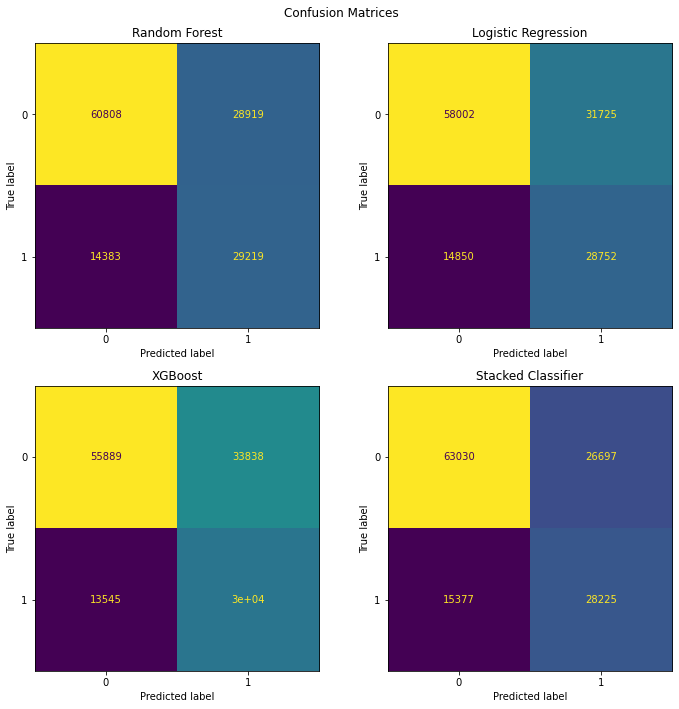

In [35]:
# fig, axs = plt.subplots(2, 2, figsize=(8, 8))
from sklearn import metrics
confusion_matrix_1 = metrics.confusion_matrix(y_test, rf_pred)
confusion_matrix_2 = metrics.confusion_matrix(y_test, lr_pred)
confusion_matrix_3 = metrics.confusion_matrix(y_test, xgb_pred)
confusion_matrix_4 = metrics.confusion_matrix(y_test, sclf_pred)

cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_1, display_labels = [0, 1])
cm_display2 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_2, display_labels = [0, 1])

cm_display3 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_3, display_labels = [0, 1])

cm_display4 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_4, display_labels = [0, 1])

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].set_title('Random Forest')
cm_display1.plot(ax=axs[0, 0], colorbar =False)
axs[0, 1].set_title('Logistic Regression')
cm_display2.plot(ax=axs[0, 1], colorbar =False)
axs[1, 0].set_title('XGBoost')
cm_display3.plot(ax=axs[1, 0], colorbar =False)
axs[1, 1].set_title('Stacked Classifier')
cm_display4.plot(ax=axs[1, 1], colorbar =False)

fig.suptitle('Confusion Matrices')

# Adjust the spacing between subplots and show the plot
plt.tight_layout()
plt.show()

### ROC-AUC 

<Figure size 720x720 with 0 Axes>

C:\Users\Lahiri\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

C:\Users\Lahiri\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

C:\Users\Lahiri\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

C:\Users\Lahiri\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

Text(0.5, 1.0, 'Receiver Operating Characteristic (ROC) Curve')

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver Operating Characteristic (ROC) Curve')

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

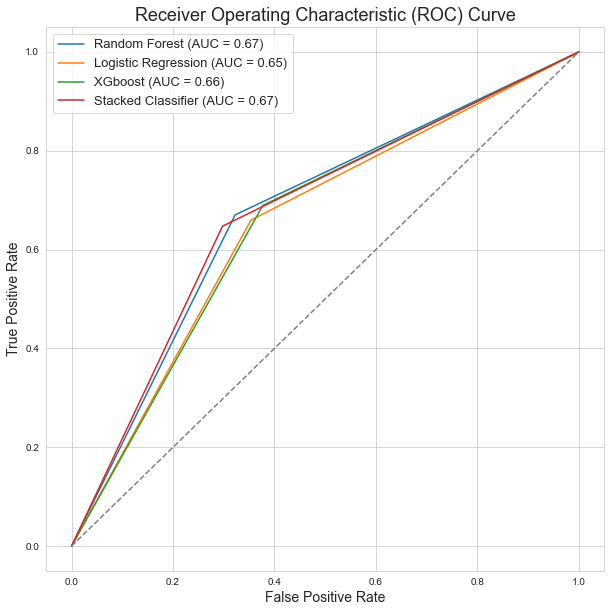

In [36]:
fpr1, tpr1, thresholds1 = roc_curve(y_test, rf_pred)
roc_auc1 = roc_auc_score(y_test, rf_pred)


fpr2, tpr2, thresholds2 = roc_curve(y_test, lr_pred)
roc_auc2 = roc_auc_score(y_test, lr_pred)


fpr3, tpr3, thresholds3 = roc_curve(y_test, xgb_pred)
roc_auc3 = roc_auc_score(y_test, xgb_pred)

fpr4, tpr4, thresholds4 = roc_curve(y_test, sclf_pred)
roc_auc4 = roc_auc_score(y_test, sclf_pred)

# Create ROC curve plot using seaborn
plt.figure(figsize=(10, 10))
sns.set_style('whitegrid')
sns.lineplot(fpr1, tpr1, label=f'Random Forest (AUC = {roc_auc1:.2f})')
sns.lineplot(fpr2, tpr2, label=f'Logistic Regression (AUC = {roc_auc2:.2f})')
sns.lineplot(fpr3, tpr3, label=f'XGboost (AUC = {roc_auc3:.2f})')
sns.lineplot(fpr4, tpr4, label=f'Stacked Classifier (AUC = {roc_auc4:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')


# Add labels and legend to the plot
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Add labels and legend to the plot
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize = 18)
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.legend(fontsize = 13)


# Show the plot
plt.show()

### Understanding Errors in our two best performing models: Random forest and stacked classifier  

In [37]:
#We now create separate dataframes with our prediction results to understand how our errors are distributed 
rf_df = pd.DataFrame({'begin': X_test_checker['LIVARAG_1'], 'true_val':y_test,'rf_pred':rf_pred})

sclf_df = pd.DataFrame({'begin': X_test_checker['LIVARAG_1'], 'true_val':y_test,'sclf_pred':sclf_pred})
                        

In [38]:
helper = rf_df[(rf_df.begin == 0)&(rf_df.true_val == 1)]
val_nh_h = helper[helper.rf_pred == 1].shape[0]/helper.shape[0]
print('Random Forest accuracy when person is not homeless at admission but homeless at discharge : %.3f' %val_nh_h)

helper = rf_df[(rf_df.begin == 0)&(rf_df.true_val == 0)]
val_nh = helper[helper.rf_pred == 0].shape[0]/helper.shape[0]
print('Random Forest accuracy when person is not homeless at admission and not homeless at discharge : %.3f' %val_nh)

helper = rf_df[(rf_df.begin == 1)&(rf_df.true_val == 1)]
val_h = helper[helper.rf_pred == 1].shape[0]/helper.shape[0]
print('Random Forest accuracy when person is  homeless at admission and homeless at discharge : %.3f' %val_h)


helper = rf_df[(rf_df.begin == 1)&(rf_df.true_val == 0)]
vale_h_nh = helper[helper.rf_pred == 0].shape[0]/helper.shape[0]
print('Random Forest accuracy when person is homeless at admission and not homeless at discharge : %.3f' %vale_h_nh)

Random Forest accuracy when person is not homeless at admission but homeless at discharge : 0.498
Random Forest accuracy when person is not homeless at admission and not homeless at discharge : 0.730
Random Forest accuracy when person is  homeless at admission and homeless at discharge : 0.696
Random Forest accuracy when person is homeless at admission and not homeless at discharge : 0.408


In [39]:
helper = sclf_df[(sclf_df.begin == 0)&(sclf_df.true_val == 1)]
val_nh_h = helper[helper.sclf_pred == 1].shape[0]/helper.shape[0]
print('Stacked Classifier accuracy when person is not homeless at admission but homeless at discharge : %.3f' %val_nh_h)

helper = sclf_df[(sclf_df.begin == 0)&(sclf_df.true_val == 0)]
val_nh = helper[helper.sclf_pred == 0].shape[0]/helper.shape[0]
print('Stacked Classifier accuracy when person is not homeless at admission and not homeless at discharge : %.3f' %val_nh)

helper = sclf_df[(sclf_df.begin == 1)&(sclf_df.true_val == 1)]
val_h = helper[helper.sclf_pred == 1].shape[0]/helper.shape[0]
print('Stacked Classifier accuracy when person is  homeless at admission and homeless at discharge : %.3f' %val_h)


helper = sclf_df[(sclf_df.begin == 1)&(sclf_df.true_val == 0)]
vale_h_nh = helper[helper.sclf_pred == 0].shape[0]/helper.shape[0]
print('Stacked Classifier accuracy when person is homeless at admission and not homeless at discharge : %.3f' %vale_h_nh)

Stacked Classifier accuracy when person is not homeless at admission but homeless at discharge : 0.478
Stacked Classifier accuracy when person is not homeless at admission and not homeless at discharge : 0.745
Stacked Classifier accuracy when person is  homeless at admission and homeless at discharge : 0.673
Stacked Classifier accuracy when person is homeless at admission and not homeless at discharge : 0.482


### Feature Importance

<Figure size 648x720 with 0 Axes>

Text(0.5, 1.0, 'Top 11 Feature Importances')

Text(0.5, 0, 'Importance Score')

Text(0, 0.5, 'Feature Name')

[Text(0, 0, 'Recieved Intensive \nAmbulatory Treatment'),
 Text(0, 1, 'Recieved Long Term non-acute \ncare in residential rehab \n in hospital'),
 Text(0, 2, 'Recieved 24 hours per day \nmedical acute care services'),
 Text(0, 3, 'Primary incomes sources other \n than wages/government assistance'),
 Text(0, 4, 'Currently Divorced'),
 Text(0, 5, 'Currently Unemployed'),
 Text(0, 6, 'Older than 45 years at admission'),
 Text(0, 7, 'DSM Diagnosis: Alcohol Abuse'),
 Text(0, 8, 'Male'),
 Text(0, 9, 'Has not attended substance use \n self-help groups within \n30 days before admission.'),
 Text(0, 10, 'Criminal Justice Referral: Probation/Parole')]

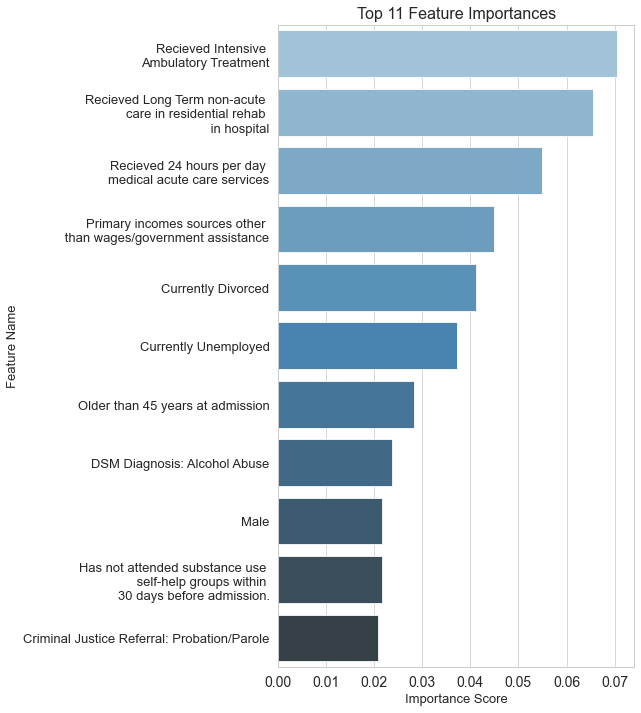

In [40]:
import seaborn as sns

importances = xgb.feature_importances_

# Get the feature names
feature_names = X_train.columns
sns.set_context("paper")
# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the top 5 features by name

plt.figure(figsize=(9,10))

#Since many of the important features are the dummies of a singl variable,
#it is more informative to look at top 11 features which are truly different 
#we hence index this way 

ax = sns.barplot(x=importances[indices][[1,2,3,4,5,6,8,9,11,12,13]], y=feature_names[indices][[1,2,3,4,5,6,8,9,11,12,13]], palette="Blues_d")
plt.title("Top 11 Feature Importances", fontsize = 16)
plt.xlabel("Importance Score", fontsize = 13)
plt.ylabel("Feature Name", fontsize = 13)
new_ytick_labels = [ 'Recieved Intensive \nAmbulatory Treatment',
                    'Recieved Long Term non-acute \ncare in residential rehab \n in hospital', 
                    'Recieved 24 hours per day \nmedical acute care services',
                    'Primary incomes sources other \n than wages/government assistance',
                    'Currently Divorced',
                    'Currently Unemployed',
                    'Older than 45 years at admission',
                    'DSM Diagnosis: Alcohol Abuse',
                    'Male',
                    'Has not attended substance use \n self-help groups within \n30 days before admission.',
                    'Criminal Justice Referral: Probation/Parole']
ax.set_yticklabels(new_ytick_labels, fontsize = 13)
ax.tick_params(axis='x', labelsize=14)
plt.tight_layout()